In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as constants

import sys
import os

dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from gen_mocks import gen_mock_tfCube
from chainTool import ChainTool
from gamma import GammaInference

sys.path.append(dir_KLens)
from KLtool import plot_specs

from IPython.display import display as ipython_display
from binnedFit_utilities import velocity_to_lambda

## 0. Generate mock data given parameters
The mock data is stored in the variable "dataInfo". (check *0. in the end of this notebook for the displays of the mock data.)

In [2]:
###### set up parameters ######

line_species='Halpha'

pars = {}
pars['g1'] = 0.0
pars['g2'] = 0.0
pars['sini'] = 0.5

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5

pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 0.12
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist

In [3]:
dataInfo = gen_mock_tfCube(pars, 'Halpha', slits='both', noise_mode=0)

## 1. GammaInference 
GammaInference is a management class to initiate the settings of the MCMC analyses.

In [4]:
GI = GammaInference(dataInfo, 
                    active_par_key=['vcirc', 'sini', 'vscale', 'r_0', 'v_0', 'g1', 'g2',  'r_hl_image', 'theta_int', 'flux'], 
                    par_fix=None, vTFR_mean=200.)

### To get the log(likelihood) given a list of input parameters.

In [5]:
active_par_fid = [GI.par_fid[key] for key in GI.active_par_key]
loglike_at_fid = GI.cal_loglike(active_par_fid)
loglike_at_fid

-0.04232041549988338

### Running MCMC analysis through emcee.
Note: this is simply a demo to test whether emcee can be successfully run on your computer. So we only set Nsteps=2. A full completed chain would need to go through ~ 100x5000 = 0.5 M iterations. 

i.e.

chainInfo = GI.run_MCMC(Nwalker=100, Nsteps=5000, outfile_MCMC='chain.pkl', save_step_size=50)

When running on a super computer with multiple CPUs, call "run_MCMC_mpi" instead to parallelize the sampling process. 

i.e.

chainInfo = GI.run_MCMC_mpi(Nwalker=100, Nsteps=5000, outfile_MCMC='chain.pkl', save_step_size=50)


In [6]:
chainInfo = GI.run_MCMC(Nwalker=30, Nsteps=2, outfile_MCMC='chain.pkl', save_step_size=2)

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

steps_taken 2
Total MCMC time (mins): 0.031065201759338378


In [7]:
chainInfo['chain'].shape

(30, 2, 10)

### *0. display dataInfo

/Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/../../BinnedFit/../TNGcube/TNGcube.py:835: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8a59566350>)

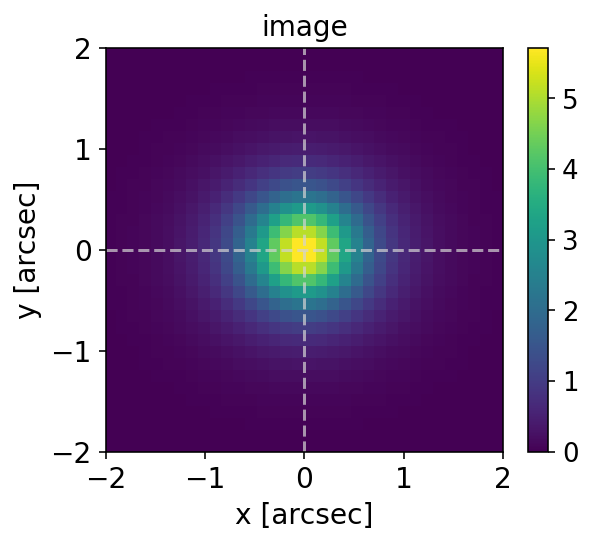

In [8]:
dataInfo['image'].display(xlim=[-2,2])

/Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/../../BinnedFit/spec2D.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8a6a18da10>)

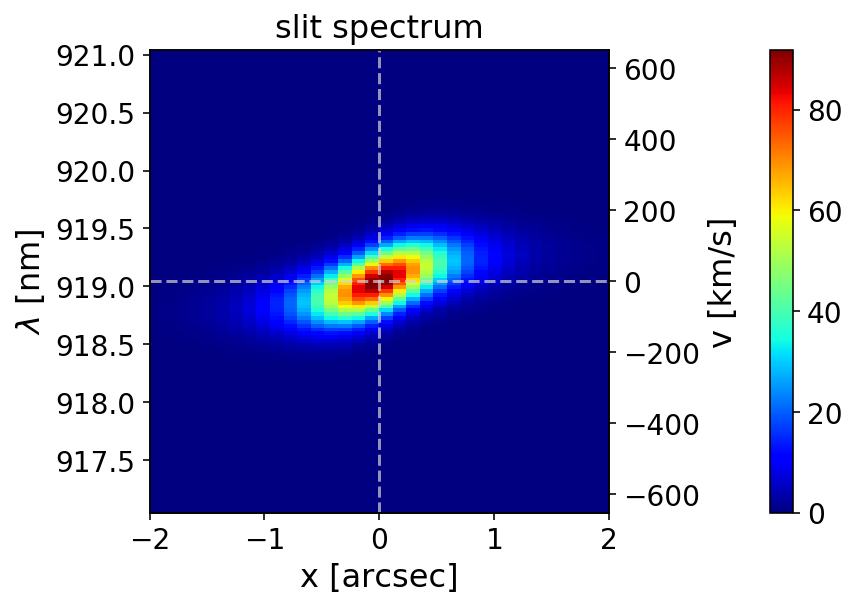

In [9]:
dataInfo['spec'][0].display(xlim=[-2,2])

(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8a60844ed0>)

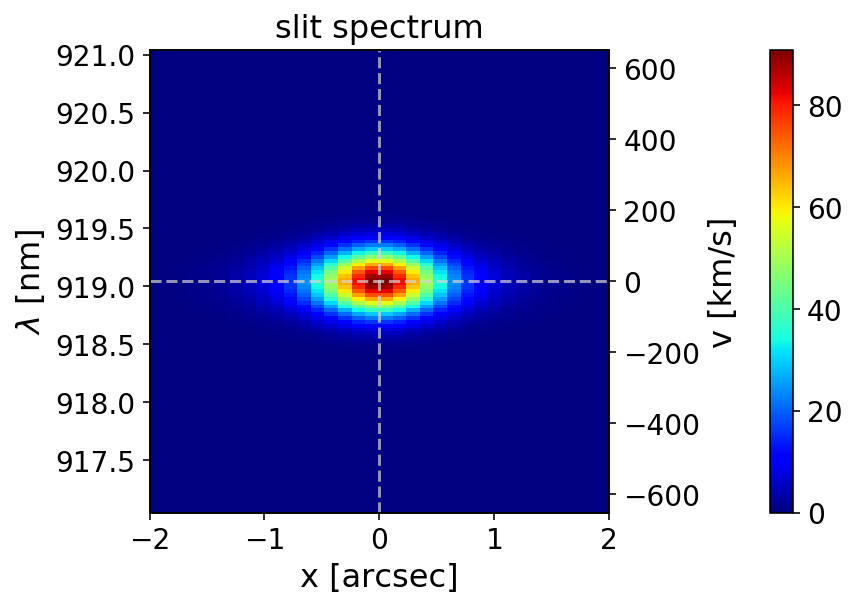

In [10]:
dataInfo['spec'][1].display(xlim=[-2,2])